In [19]:
cd /home/bart/Documents/repos/L2M/visual-search-nets/data/results/

/home/bart/Documents/repos/L2M/visual-search-nets/data/results


In [2]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

In [15]:
results_dir = Path('/home/bart/Documents/repos/L2M/visual-search-nets/data/results/')
data_prep_dir = Path('/home/bart/Documents/repos/L2M/visual-search-nets/data/data_prepd_for_nets/')

In [59]:
nets = ('alexnet', 'VGG16')
train_types = ('finetune', 'train')
stims = ('2_v_5', 'RVvGV', 'RVvRHGV')
target_condition = ('present', 'absent')
header = ['net_name', 'train_type', 'net_number', 'stimulus', 'target_condition', 'set_size', 'accuracy']

In [64]:
rows = []
for train_type in train_types:
    for net in nets:
        if net=='VGG16' and train_type=='train':
            continue
        else:
            for stim in stims:
                gz_fname = data_prep_dir.joinpath(f'{net}_{train_type}_{stim}_data.gz')
                data_dict = joblib.load(gz_fname)
                y_test = data_dict['y_test']
                set_size_vec_test = data_dict['set_size_vec_test']
                set_sizes = data_dict['set_sizes_by_stim_type'][stim]
                results_path = list(results_dir.joinpath(f'{net}_{train_type}_{stim}').glob(f'test_{net}*.gz'))
                assert len(results_path) == 1
                results_dict = joblib.load(results_path[0])
                for net_num in range(4):
                    ppm = results_dict['predictions_per_model_dict']
                    key = [key for key in ppm.keys() if f'net_number_{net_num}' in key][0]
                    y_pred = ppm[key]
                    for target_cond in target_condition:
                        for set_size in set_sizes:
                            if target_cond == 'present':
                                inds_this_cond = np.where(np.logical_and(y_test == 1, set_size_vec_test == set_size))
                            elif target_cond == 'absent':
                                inds_this_cond = np.where(np.logical_and(y_test == 0, set_size_vec_test == set_size))
                            acc = np.sum(y_pred[inds_this_cond] == y_test[inds_this_cond]) / y_test[inds_this_cond].shape[0]
                            row = [net, train_type, net_num, stim, target_cond, set_size, acc]
                            rows.append(row)

In [65]:
test_df = pd.DataFrame.from_records(rows, columns=header)

In [4]:
cd /home/bart/Documents/repos/L2M/visual-search-nets/data/results/

/home/bart/Documents/repos/L2M/visual-search-nets/data/results


In [82]:
test_df.to_csv('all-test-results.csv')

In [83]:
test_df = pd.read_csv('all-test-results.csv')

In [6]:
test_df.head()

,Unnamed: 0,net_name,train_type,net_number,stimulus,target_condition,set_size,accuracy
0,0,alexnet,finetune,0,2_v_5,present,1,0.95
1,1,alexnet,finetune,0,2_v_5,present,2,0.69
2,2,alexnet,finetune,0,2_v_5,present,4,0.48
3,3,alexnet,finetune,0,2_v_5,present,8,0.43
4,4,alexnet,finetune,0,2_v_5,absent,1,1.00


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

def acc_v_set_size_df(df, net_name, train_type, stimulus,
                      set_sizes=(1, 2, 4, 8), ax=None,
                      title=None, save_as=None, figsize=(10, 5),
                      set_xlabel=False, set_ylabel=False, set_ylim=True,
                      ylim=(0, 1.1), plot_mean=True, add_legend=False,
                      task_name=None):
    """plot accuracy as a function of visual search task set size
    for models trained on a single task or dataset

    Accepts a Pandas dataframe and column names that determine what to plot

    Parameters
    ----------
    results
        path to results.gz file saved after measuring accuracy of trained networks
        on test set of visual search stimuli
    set_sizes : list
        of int, set sizes of visual search stimuli. Default is [1, 2, 4, 8].
    ax : matplotlib.Axis
        axis on which to plot figure. Default is None, in which case a new figure with
        a single axis is created for the plot.
    title : str
        string to use as title of figure. Default is None.
    save_as : str
        path to directory where figure should be saved. Default is None, in which
        case figure is not saved.
    figsize : tuple
        (width, height) in inches. Default is (10, 5). Only used if ax is None and a new
        figure is created.
    set_xlabel : bool
        if True, set the value of xlabel to "set size". Default is False.
    set_ylabel : bool
        if True, set the value of ylabel to "accuracy". Default is False.
    set_ylim : bool
        if True, set the y-axis limits to the value of ylim.
    ylim : tuple
        with two elements, limits for y-axis. Default is (0, 1.1).
    plot_mean : bool
        if True, find mean accuracy and plot as a separate solid line. Default is True.
    add_legend : bool
        if True, add legend to axis. Default is False.
    task_name : str


    Returns
    -------
    None
    """
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(figsize)

    df = df.loc[(df['net_name'] == net_name) & (df['train_type'] == train_type) & (df['stimulus'] == stimulus)]

    acc_target_present = []
    acc_target_absent = []
    set_sizes = None
    net_nums = df['net_number'].unique()
    for net_num in net_nums:
        df_this_net_num = df.loc[(df['net_number'] == net_num)]
        for targ_cond in ['present', 'absent']:
            df_this_cond = df_this_net_num.loc[(df_this_net_num['target_condition'] == targ_cond)]
            acc = df_this_cond['accuracy'].values
            if targ_cond == 'present':
                acc_target_present.append(acc)
            elif targ_cond == 'absent':
                acc_target_absent.append(acc)

            set_size = df_this_cond['set_size'].values
            if set_sizes is None:
                set_sizes = set_size
            else:
                assert np.array_equal(set_sizes, set_size)

    for arr_acc_present, arr_acc_absent in zip(acc_target_present, acc_target_absent):
        ax.plot(set_sizes, arr_acc_present, color='violet', linestyle='--', marker='o')
        ax.plot(set_sizes, arr_acc_absent, color='lightgreen', linestyle='--', marker='o')
    mn_acc_present = np.asarray(acc_target_present).mean(axis=0)
    ax.plot(set_sizes, mn_acc_present, color='magenta', label='mean acc\ntarget present')
    mn_acc_absent = np.asarray(acc_target_absent).mean(axis=0)
    ax.plot(set_sizes, mn_acc_absent, color='lawngreen', label='mean acc\ntarget absent')


    ax.set_xticks(set_sizes)

    if title:
        ax.set_title(title)
    if set_xlabel:
        ax.set_xlabel('set size')
    if set_ylabel:
        ax.set_ylabel('accuracy')
    if set_ylim:
        ax.set_ylim(ylim)

    if add_legend:
        ax.legend()

    if save_as:
        plt.savefig(save_as)

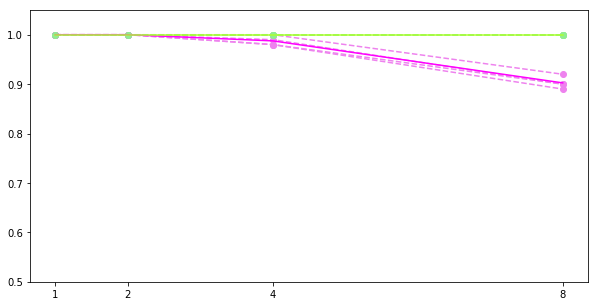

In [78]:
acc_v_set_size_df(test_df, 'alexnet', 'finetune', 'RVvGV', ylim=(0.5, 1.05))

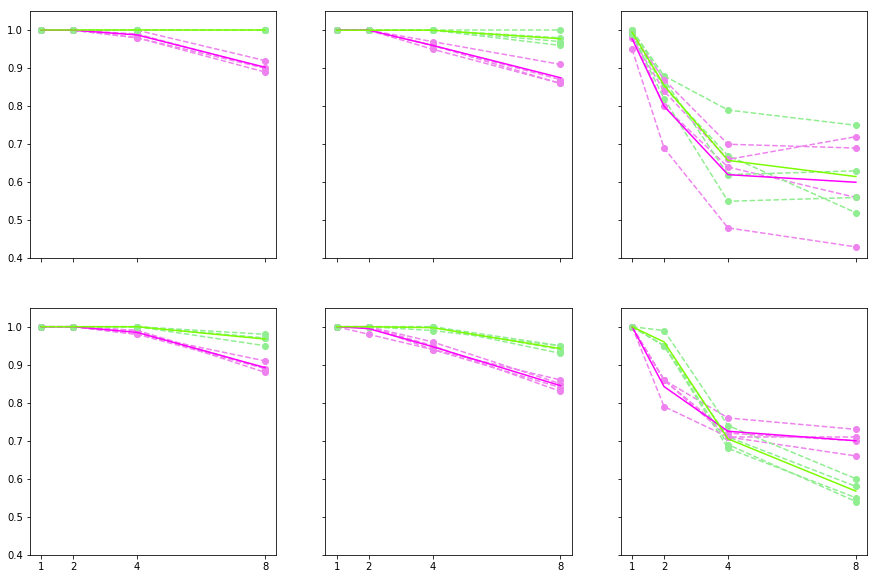

In [81]:
figsize=(15,10)
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for row, net in enumerate(('alexnet', 'VGG16')):
    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['feature', 'conjunction', 'spatial configuration'],
        ['RVvGV', 'RVvRHGV', '2_v_5'])):
            if net == 'alexnet':
                subdir = f'{net}_finetune_{stim_abbrev}/test_{net}_trained_200_epochs.gz'
            elif net == 'VGG16':
                subdir = f'{net}_finetune_{stim_abbrev}/test_VGG16_trained_200_epochs.gz'

            acc_v_set_size_df(test_df, net, 'finetune', stim_abbrev, ylim=(0.4, 1.05), ax=ax[row, col])